In [1]:
import glob
import os

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, Subset

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score
)

import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Custom transform to avoid torchvision compatibility issues
class CustomTransform:
    def __init__(self, size):
        self.size = size
    
    def __call__(self, img):
        # Resize image
        img = img.resize(self.size, Image.LANCZOS)
        # Convert to tensor
        img_array = np.array(img, dtype=np.float32) / 255.0
        img_tensor = torch.from_numpy(img_array).unsqueeze(0)  # Add channel dimension
        return img_tensor

BATCH_SIZE = 4
MANUAL_SEED = 1
HIDDEN_SIZE = 256
# INPUT_SIZE will be determined dynamically from DGM features

In [2]:
if torch.cuda.is_available():
    num_devices = torch.cuda.device_count()
    print(f"Found {num_devices} CUDA device(s):")
    for i in range(num_devices):
        print(f"CUDA:{i} - {torch.cuda.get_device_name(i)}")
else:
    print("CUDA is not available. Using CPU.")

Found 1 CUDA device(s):
CUDA:0 - NVIDIA GeForce RTX 3050 Laptop GPU


## Custom Dataset with User ID Extraction

This class processes scanpath images and 1-row DGM features, extracting user IDs from filenames for leave-one-user-out cross-validation.

In [3]:
class ScanpathDataset(Dataset):
    def __init__(self, img_root, dgm_root, transform=None):
        self.samples = []
        self.transform = transform
        self.label_map = {"literate": 0, "illiterate": 1}
        self.feature_dim = None
        self.valid_columns = None

        for label_name, label in self.label_map.items():
            img_dir = os.path.join(img_root, label_name)
            dgm_dir = os.path.join(dgm_root, label_name)

            # Iterate through user folders in DGM directory
            for user_folder in os.listdir(dgm_dir):
                user_path = os.path.join(dgm_dir, user_folder)
                if not os.path.isdir(user_path):
                    continue
                
                user_id = int(user_folder.split('_')[1])
                
                # Process all CSV files in user folder
                for csv_file in glob.glob(os.path.join(user_path, "*.csv")):
                    base = os.path.splitext(os.path.basename(csv_file))[0]
                    
                    # DGM filename format: user_x_question_x_ID_x.csv
                    # Scanpath filename format: user_x_question_x.png
                    # Extract user_x_question_x part (remove _ID_x suffix)
                    parts = base.split('_ID_')
                    if len(parts) > 0:
                        scanpath_base = parts[0]
                    else:
                        scanpath_base = base
                    
                    # Look for corresponding image in scanpath folder (flat structure)
                    img_path = os.path.join(img_dir, scanpath_base + ".png")
                    
                    if os.path.exists(img_path):
                        self.samples.append((img_path, csv_file, label, user_id))
        
        print(f"Loaded {len(self.samples)} samples from {len(self.get_unique_users())} users")
        
        # Identify valid columns (not all null/NaN/zero)
        self._identify_valid_columns()
    
    def _identify_valid_columns(self):
        """Identify columns that are not all null, NaN, or zero across all samples."""
        if len(self.samples) == 0:
            return
        
        print("Analyzing features to identify valid columns...")
        all_features = []
        
        # Collect all feature rows
        for _, dgm_path, _, _ in self.samples:
            df = pd.read_csv(dgm_path)
            if len(df) > 0:
                features = df.iloc[0].values.astype(np.float32)
                features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
                all_features.append(features)
        
        if len(all_features) == 0:
            return
        
        # Stack all features
        all_features = np.array(all_features)
        
        # Identify valid columns (not all zero/null)
        valid_mask = np.any(all_features != 0, axis=0)
        self.valid_columns = np.where(valid_mask)[0]
        
        removed_count = all_features.shape[1] - len(self.valid_columns)
        print(f"Removed {removed_count} columns (all null/NaN/zero)")
        print(f"Keeping {len(self.valid_columns)} valid feature columns")
        
        # Update feature dimension
        self.feature_dim = len(self.valid_columns)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        from PIL import Image
        img_path, dgm_path, label, user_id = self.samples[idx]

        # Load image
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)

        # Load DGM features (1 row of features)
        df = pd.read_csv(dgm_path)
        
        if len(df) == 0:
            raise ValueError(f"CSV file {dgm_path} is empty")
        
        # Get first row of features
        features = df.iloc[0].values.astype(np.float32)
        
        # Handle NaN and inf values
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
        
        # Filter to valid columns only
        if self.valid_columns is not None:
            features = features[self.valid_columns]
        
        features = torch.tensor(features, dtype=torch.float32)

        return img, features, label, user_id
    
    def get_user_ids(self):
        return [sample[3] for sample in self.samples]
    
    def get_unique_users(self):
        return sorted(set(self.get_user_ids()))
    
    def get_feature_dim(self):
        if self.feature_dim is None and len(self.samples) > 0:
            # Get feature dimension from first sample
            _, features, _, _ = self[0]
            self.feature_dim = len(features)
        return self.feature_dim

In [4]:
def collate_fn(batch):
    images, features, labels, user_ids = zip(*batch)

    images = torch.stack(images)
    features = torch.stack(features)  # DGM features are fixed-size vectors

    labels = torch.tensor(labels, dtype=torch.long)
    user_ids = torch.tensor(user_ids, dtype=torch.long)

    return images, features, labels, user_ids


## VTNet Model with Multi-Modal Fusion

This model combines:
- **CNN branch**: Extracts spatial features from scanpath images (visual patterns)
- **DGM branch**: Processes discrete graph metric features (aggregated eye-tracking statistics)
- **Fusion mechanism**: Combines CNN features with DGM features for classification

The model leverages both spatial scanpath patterns and statistical DGM features for robust literacy classification.

In [5]:
class VTNet(nn.Module):
    def __init__(self,
                 dgm_input_size,
                 output_size=2,
                 n_channels_1=6,
                 kernel_size_1=5,
                 n_channels_2=16,
                 kernel_size_2=5,
                 img_n_vert=150,
                 img_n_hor=150,
                 dgm_hidden_size=128):
        super(VTNet, self).__init__()

        self.n_channels_2 = n_channels_2

        # --- CNN branch ---
        self.conv1 = nn.Conv2d(1, n_channels_1, kernel_size=kernel_size_1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(n_channels_1, n_channels_2, kernel_size=kernel_size_2)

        # calculate CNN output size
        conv1_out_vert = img_n_vert - kernel_size_1 + 1
        conv1_out_hor = img_n_hor - kernel_size_1 + 1
        mp1_out_vert = (conv1_out_vert - 2) // 2 + 1
        mp1_out_hor = (conv1_out_hor - 2) // 2 + 1
        conv2_out_vert = mp1_out_vert - kernel_size_2 + 1
        conv2_out_hor = mp1_out_hor - kernel_size_2 + 1
        mp2_out_vert = (conv2_out_vert - 2) // 2 + 1
        mp2_out_hor = (conv2_out_hor - 2) // 2 + 1

        cnn_output_size = n_channels_2 * mp2_out_hor * mp2_out_vert
        self.fc_cnn = nn.Linear(cnn_output_size, 50)
        
        # --- DGM branch ---
        self.fc_dgm1 = nn.Linear(dgm_input_size, dgm_hidden_size)
        self.fc_dgm2 = nn.Linear(dgm_hidden_size, 50)
        self.dropout_dgm = nn.Dropout(0.3)
        
        # --- Fusion layers ---
        self.fc_fusion = nn.Linear(100, 50)  # 50 from CNN + 50 from DGM
        self.fc_output = nn.Linear(50, output_size)
        self.dropout_fusion = nn.Dropout(0.3)

    def forward(self, scan_path, dgm_features):
        # --- CNN branch ---
        x_cnn = self.pool(F.relu(self.conv1(scan_path)))
        x_cnn = self.pool(F.relu(self.conv2(x_cnn)))
        x_cnn = x_cnn.view(x_cnn.size(0), -1)
        x_cnn = F.relu(self.fc_cnn(x_cnn))
        
        # --- DGM branch ---
        x_dgm = F.relu(self.fc_dgm1(dgm_features))
        x_dgm = self.dropout_dgm(x_dgm)
        x_dgm = F.relu(self.fc_dgm2(x_dgm))
        
        # --- Fusion ---
        x = torch.cat((x_cnn, x_dgm), dim=1)
        x = F.relu(self.fc_fusion(x))
        x = self.dropout_fusion(x)
        x = self.fc_output(x)
        
        return x

## Leave-One-User-Out Cross-Validation

This section performs leave-one-user-out cross-validation where:
1. Each unique user is held out as a test set
2. All other users are used for training
3. The model is trained and evaluated for each user
4. Results are aggregated across all users

This approach evaluates how well the model generalizes to completely unseen users.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = CustomTransform((150, 150))

dataset = ScanpathDataset("../data/scanpaths/all", "../data/1_row_DGMs/all", transform=transform)
print("Total samples:", len(dataset))

if len(dataset) == 0:
    print("\n" + "="*60)
    print("ERROR: No samples loaded! Please check:")
    print("="*60)
    print("1. Scanpath images directory: ../data/scanpaths/all/")
    print("2. DGM features directory: ../data/1_row_DGMs/all/")
    print("3. Both should have literate/ and illiterate/ subdirectories")
    print("4. Each should have user_X/ folders inside")
    print("5. DGM CSVs and scanpath PNGs should have matching filenames")
    raise ValueError("No samples found in dataset")

# Get feature dimension from dataset
feature_dim = dataset.get_feature_dim()
print(f"DGM feature dimension: {feature_dim}")

# ------------------------------------------------
# Get unique users for LOUO CV
# ------------------------------------------------
unique_users = dataset.get_unique_users()
print(f"Number of unique users: {len(unique_users)}")
print(f"User IDs: {unique_users}")

# Get all user IDs from dataset
all_user_ids = dataset.get_user_ids()

# Store metrics for each user
user_metrics = []
per_user_results = []

# ------------------------------------------------
# Leave-One-User-Out Cross-Validation
# ------------------------------------------------
for fold_idx, test_user in enumerate(unique_users):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx+1}/{len(unique_users)} - Testing on User {test_user}")
    print(f"{'='*60}")
    
    # Split dataset: train on all users except test_user
    train_indices = [i for i, uid in enumerate(all_user_ids) if uid != test_user]
    test_indices = [i for i, uid in enumerate(all_user_ids) if uid == test_user]
    
    print(f"Training samples: {len(train_indices)}")
    print(f"Test samples: {len(test_indices)}")
    
    # Skip if no training or test samples
    if len(train_indices) == 0 or len(test_indices) == 0:
        print(f"Warning: Skipping user {test_user} due to insufficient samples")
        continue
    
    # Create subsets
    train_subset = Subset(dataset, train_indices)
    test_subset = Subset(dataset, test_indices)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=4, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_subset, batch_size=4, shuffle=False, collate_fn=collate_fn)
    
    # Initialize model for this fold
    model = VTNet(dgm_input_size=feature_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-4)
    
    # -----------------------------
    # Training
    # -----------------------------
    num_epochs = 50
    best_train_acc = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0
        
        for images, dgm_features, labels, user_ids in train_loader:
            images, dgm_features, labels = (
                images.to(device),
                dgm_features.to(device),
                labels.to(device)
            )
            optimizer.zero_grad()
            outputs = model(images, dgm_features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_acc = 100 * correct / total
        avg_loss = running_loss / len(train_loader)
        
        # Print every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Train Acc: {train_acc:.2f}%")
    
    # -----------------------------
    # Testing on held-out user
    # -----------------------------
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for images, dgm_features, labels, user_ids in test_loader:
            images, dgm_features, labels = (
                images.to(device),
                dgm_features.to(device),
                labels.to(device)
            )
            outputs = model(images, dgm_features)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
    
    # Compute metrics for this user
    acc = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_true, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_true, all_preds, average="macro", zero_division=0)
    
    user_metrics.append((acc, precision, recall, f1))
    per_user_results.append({
        'user_id': test_user,
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'n_samples': len(test_indices)
    })
    
    print(f"\nUser {test_user} Results:")
    print(f"  Accuracy:  {acc:.3f}")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall:    {recall:.3f}")
    print(f"  F1-score:  {f1:.3f}")

# ------------------------------------------------
# Average metrics across all users
# ------------------------------------------------
if len(user_metrics) == 0:
    print("\n" + "="*60)
    print("ERROR: No users were successfully processed!")
    print("="*60)
    print("\nPossible issues:")
    print("1. No matching scanpath images found for DGM files")
    print("2. Directory structure mismatch")
    print("3. All users had insufficient samples")
    print("\nPlease check:")
    print(f"- Scanpath images exist in: ../data/scanpaths/all/[literate|illiterate]/user_X/")
    print(f"- DGM files exist in: ../data/1_row_DGMs/all/[literate|illiterate]/user_X/")
    print(f"- File names match between directories")
else:
    user_metrics = np.array(user_metrics)
    mean_metrics = user_metrics.mean(axis=0)
    std_metrics = user_metrics.std(axis=0)

    print(f"\n{'='*60}")
    print("LEAVE-ONE-USER-OUT CROSS-VALIDATION RESULTS")
    print(f"{'='*60}")
    print(f"Accuracy:  {mean_metrics[0]:.3f} ± {std_metrics[0]:.3f}")
    print(f"Precision: {mean_metrics[1]:.3f} ± {std_metrics[1]:.3f}")
    print(f"Recall:    {mean_metrics[2]:.3f} ± {std_metrics[2]:.3f}")
    print(f"F1-score:  {mean_metrics[3]:.3f} ± {std_metrics[3]:.3f}")
    print(f"{'='*60}")

Loaded 1499 samples from 30 users
Analyzing features to identify valid columns...
Removed 15 columns (all null/NaN/zero)
Keeping 50 valid feature columns
Total samples: 1499
DGM feature dimension: 50
Number of unique users: 30
User IDs: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

Fold 1/30 - Testing on User 1
Training samples: 1449
Test samples: 50
Epoch [10/50] | Loss: 0.7773 | Train Acc: 55.28%
Epoch [20/50] | Loss: 0.8107 | Train Acc: 58.18%
Epoch [30/50] | Loss: 0.6757 | Train Acc: 58.59%
Epoch [40/50] | Loss: 0.6770 | Train Acc: 58.59%
Epoch [50/50] | Loss: 0.7263 | Train Acc: 58.52%

User 1 Results:
  Accuracy:  0.000
  Precision: 0.000
  Recall:    0.000
  F1-score:  0.000

Fold 2/30 - Testing on User 2
Training samples: 1449
Test samples: 50
Epoch [10/50] | Loss: 1.5091 | Train Acc: 52.59%
Epoch [20/50] | Loss: 0.7214 | Train Acc: 52.38%
Epoch [30/50] | Loss: 0.6881 | Train Acc: 46.38%
Epoch [40/50] | Loss: 0

## Per-User Results Analysis

View detailed results for each individual user.

In [7]:
# Create DataFrame with per-user results
results_df = pd.DataFrame(per_user_results)
results_df = results_df.sort_values('accuracy', ascending=False)

print("\nPer-User Performance (sorted by accuracy):")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('vtnet_dgms_1row_louo_results.csv', index=False)
print("\nResults saved to 'vtnet_dgms_1row_louo_results.csv'")


Per-User Performance (sorted by accuracy):
 user_id  accuracy  precision  recall  f1_score  n_samples
      17       1.0        1.0     1.0       1.0         50
      13       1.0        1.0     1.0       1.0         50
      30       1.0        1.0     1.0       1.0         50
      27       1.0        1.0     1.0       1.0         50
      25       1.0        1.0     1.0       1.0         50
      24       1.0        1.0     1.0       1.0         50
      22       1.0        1.0     1.0       1.0         50
      19       1.0        1.0     1.0       1.0         50
      18       1.0        1.0     1.0       1.0         50
       2       1.0        1.0     1.0       1.0         50
      15       1.0        1.0     1.0       1.0         50
      32       1.0        1.0     1.0       1.0         50
       7       1.0        1.0     1.0       1.0         50
       6       1.0        1.0     1.0       1.0         50
      11       1.0        1.0     1.0       1.0         49
       3    

## Visualize Results Distribution

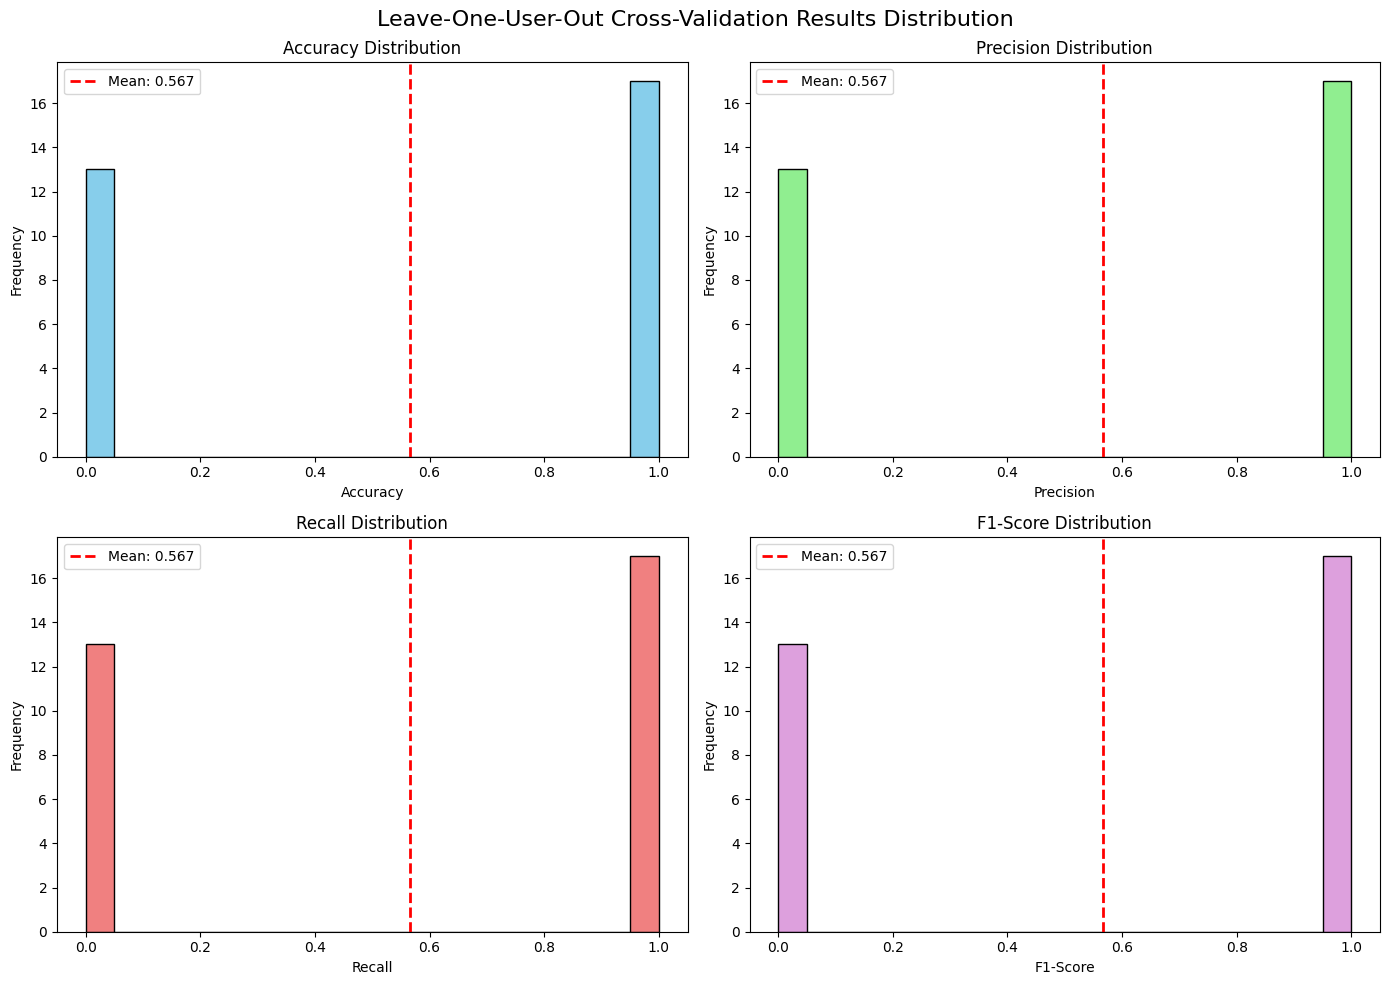

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Leave-One-User-Out Cross-Validation Results Distribution', fontsize=16)

# Accuracy distribution
axes[0, 0].hist(results_df['accuracy'], bins=20, color='skyblue', edgecolor='black')
axes[0, 0].axvline(mean_metrics[0], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[0]:.3f}')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Accuracy Distribution')
axes[0, 0].legend()

# Precision distribution
axes[0, 1].hist(results_df['precision'], bins=20, color='lightgreen', edgecolor='black')
axes[0, 1].axvline(mean_metrics[1], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[1]:.3f}')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Precision Distribution')
axes[0, 1].legend()

# Recall distribution
axes[1, 0].hist(results_df['recall'], bins=20, color='lightcoral', edgecolor='black')
axes[1, 0].axvline(mean_metrics[2], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[2]:.3f}')
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Recall Distribution')
axes[1, 0].legend()

# F1-score distribution
axes[1, 1].hist(results_df['f1_score'], bins=20, color='plum', edgecolor='black')
axes[1, 1].axvline(mean_metrics[3], color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_metrics[3]:.3f}')
axes[1, 1].set_xlabel('F1-Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('F1-Score Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## Box Plot of Metrics

C:\Users\eloto\AppData\Local\Temp\ipykernel_24440\4232388650.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = plt.boxplot([metrics_data['accuracy'], metrics_data['precision'],


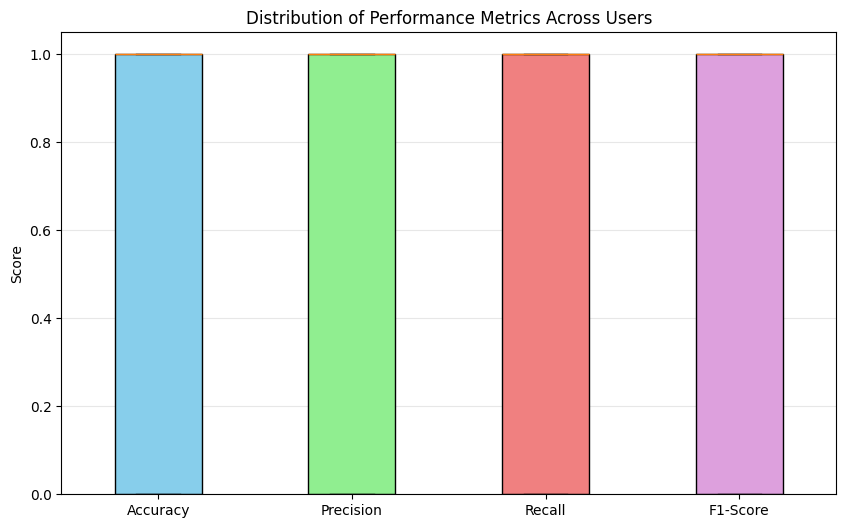

In [9]:
# Create box plot for all metrics
metrics_data = results_df[['accuracy', 'precision', 'recall', 'f1_score']]

plt.figure(figsize=(10, 6))
bp = plt.boxplot([metrics_data['accuracy'], metrics_data['precision'], 
                   metrics_data['recall'], metrics_data['f1_score']],
                  labels=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                  patch_artist=True)

# Color the boxes
colors = ['skyblue', 'lightgreen', 'lightcoral', 'plum']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Score')
plt.title('Distribution of Performance Metrics Across Users')
plt.grid(axis='y', alpha=0.3)
plt.ylim(0, 1.05)
plt.show()

## User Performance Heatmap

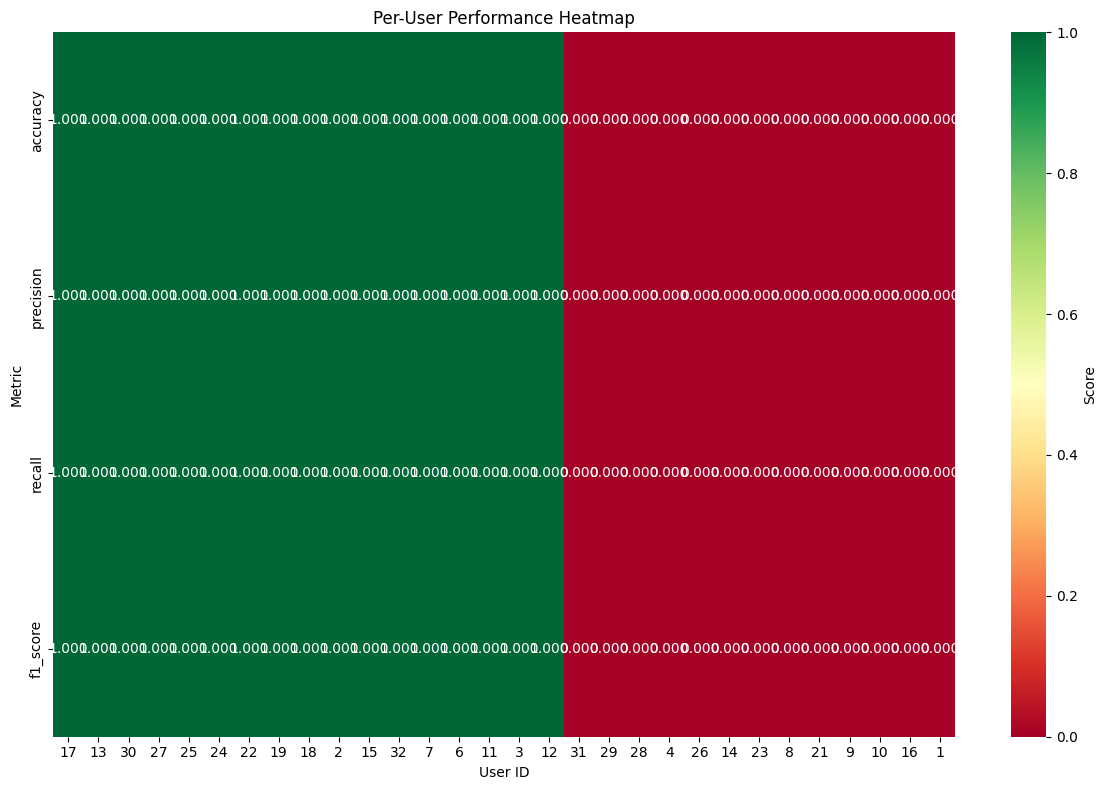

In [10]:
# Create heatmap of user performance
plt.figure(figsize=(12, 8))
heatmap_data = results_df.set_index('user_id')[['accuracy', 'precision', 'recall', 'f1_score']]
sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlGn', 
            cbar_kws={'label': 'Score'}, vmin=0, vmax=1)
plt.title('Per-User Performance Heatmap')
plt.xlabel('User ID')
plt.ylabel('Metric')
plt.tight_layout()
plt.show()

## Statistical Summary

In [11]:
# Detailed statistical summary
print("\nDetailed Statistical Summary:")
print("="*60)
summary_stats = results_df[['accuracy', 'precision', 'recall', 'f1_score']].describe()
print(summary_stats)

# Best and worst performing users
print("\n" + "="*60)
print("Top 5 Users by Accuracy:")
print(results_df.nlargest(5, 'accuracy')[['user_id', 'accuracy', 'f1_score', 'n_samples']])

print("\nBottom 5 Users by Accuracy:")
print(results_df.nsmallest(5, 'accuracy')[['user_id', 'accuracy', 'f1_score', 'n_samples']])


Detailed Statistical Summary:
        accuracy  precision     recall   f1_score
count  30.000000  30.000000  30.000000  30.000000
mean    0.566667   0.566667   0.566667   0.566667
std     0.504007   0.504007   0.504007   0.504007
min     0.000000   0.000000   0.000000   0.000000
25%     0.000000   0.000000   0.000000   0.000000
50%     1.000000   1.000000   1.000000   1.000000
75%     1.000000   1.000000   1.000000   1.000000
max     1.000000   1.000000   1.000000   1.000000

Top 5 Users by Accuracy:
    user_id  accuracy  f1_score  n_samples
15       17       1.0       1.0         50
11       13       1.0       1.0         50
27       30       1.0       1.0         50
24       27       1.0       1.0         50
22       25       1.0       1.0         50

Bottom 5 Users by Accuracy:
    user_id  accuracy  f1_score  n_samples
28       31       0.0       0.0         50
26       29       0.0       0.0         50
25       28       0.0       0.0         50
3         4       0.0       0.0   